In [76]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as pl
import scanpy as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
results_file = './write/krumsiek11_blobs.h5ad'

scanpy==1.5.1 anndata==0.7.3 umap==0.4.4 numpy==1.19.0 scipy==1.5.0 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.7.0 leidenalg==0.8.1


In [2]:
adata_krumsiek11 = sc.datasets.krumsiek11()
adata_krumsiek11.obs_names_make_unique()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'cell_type' as categorical


In [3]:
adata_blobs = sc.datasets.blobs(cluster_std=0.5, n_centers=2)
adata_blobs.var_names = adata_krumsiek11.var_names
adata = adata_krumsiek11.concatenate(adata_blobs, index_unique='-')
adata.uns = adata_krumsiek11.uns
adata.write(results_file)

... storing 'cell_type' as categorical
... storing 'blobs' as categorical


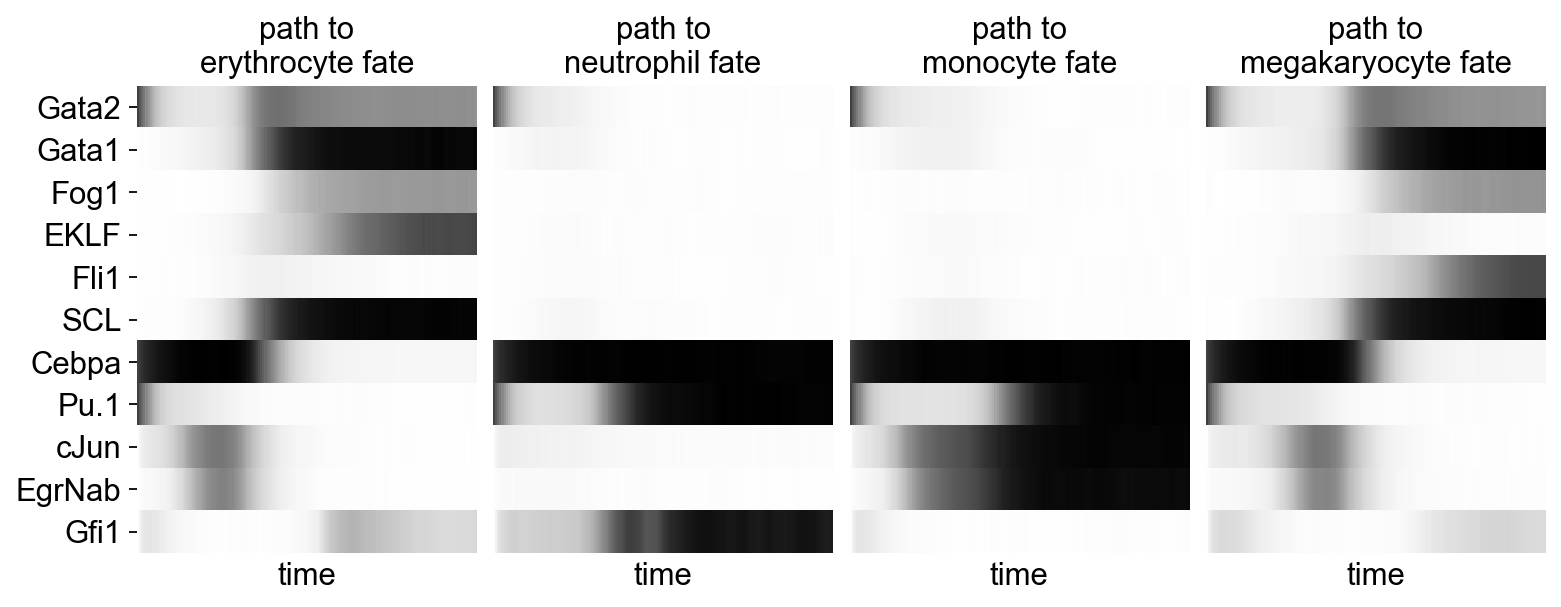

In [4]:
_, axs = pl.subplots(ncols=4, figsize=(10, 4), gridspec_kw={'wspace': 0.05, 'left': 0.1})
pl.subplots_adjust(left=0.05, right=0.98, top=0.88)
for ititle, (title, idcs) in enumerate(
    [('erythrocyte', (160, 320)), ('neutrophil', (480, 640)), 
     ('monocyte', (0, 160)), ('megakaryocyte', (320, 480)), ]):
    pl.sca(axs[ititle])
    img = pl.imshow(adata.X[idcs[0]:idcs[1]].T, aspect='auto', interpolation='nearest', cmap='Greys')
    if ititle == 0: pl.yticks(range(adata.n_vars), adata.var_names)
    else: pl.yticks([])
    pl.title('path to\n{} fate'.format(title))
    pl.xticks([])
    pl.grid(False)
    pl.xlabel('time')
    axs[ititle].set_frame_on(False)
pl.savefig('./figures/krumsiek11_timeseries_heatmap.pdf')    
pl.show()

In [5]:
sc.pp.neighbors(adata, n_neighbors=30)  # generate a neighborhood graph of single cells
sc.tl.draw_graph(adata)  # draw this graph using standard drawing algorithms

computing neighbors
    using data matrix X directly


/Users/reang/anaconda3/envs/compbio/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:04)


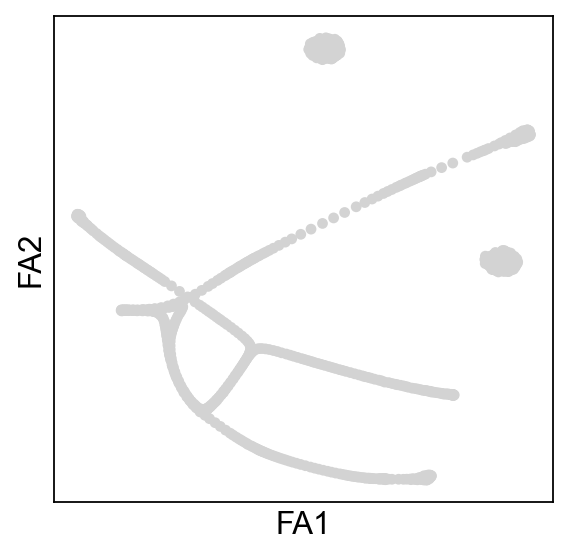

In [6]:
sc.pl.draw_graph(adata)

In [7]:
adata.write(results_file)

In [8]:
adata = sc.read(results_file)

In [9]:
sc.tl.louvain(adata, resolution=2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


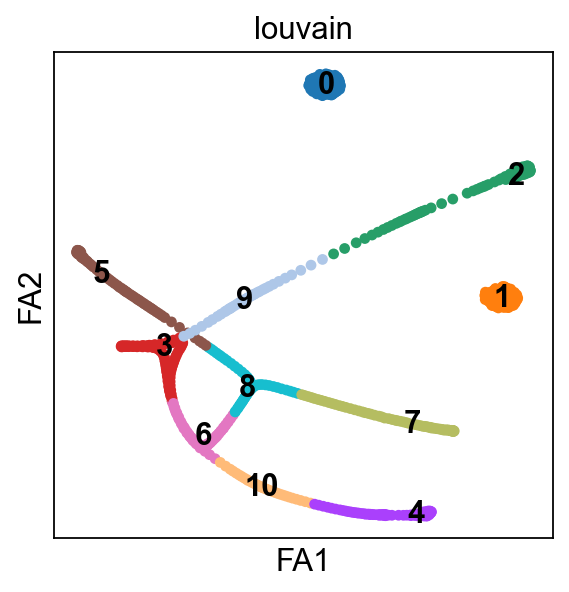

In [10]:
sc.pl.draw_graph(adata, color='louvain', legend_loc='on data')

In [11]:
sc.tl.louvain(adata, resolution=1, restrict_to=('louvain', ['4']))

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)


In [12]:
adata.obs['clusters'] = adata.obs['louvain_R']
adata.rename_categories('clusters', [str(i) for i in range(len(adata.obs['clusters'].cat.categories))])

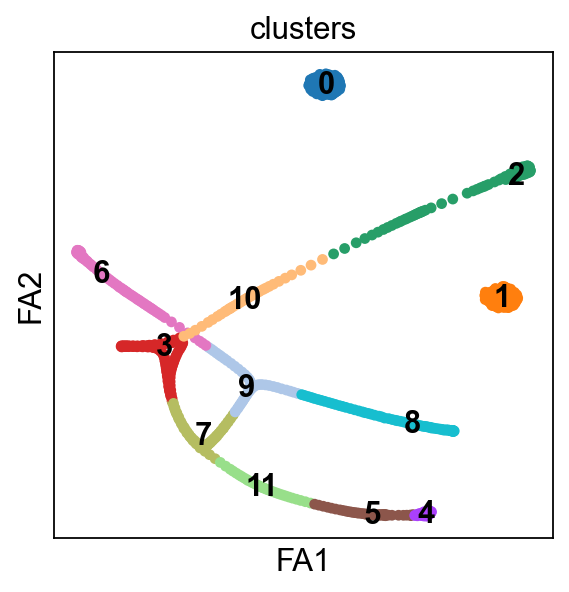

In [13]:
sc.pl.draw_graph(adata, color='clusters', legend_loc='on data')

Annotate the clusters

In [14]:
adata.obs['clusters'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'], dtype='object')

In [15]:
new_categories = ['0', '1', '2', '3/Neu', '4', '5/Stem', '6', '7/Mo', '8/Ery', '9/Mk', '10', '11']
adata.rename_categories('clusters', new_categories)
del adata.uns['highlights']  # remove the annotation of the single datapoints

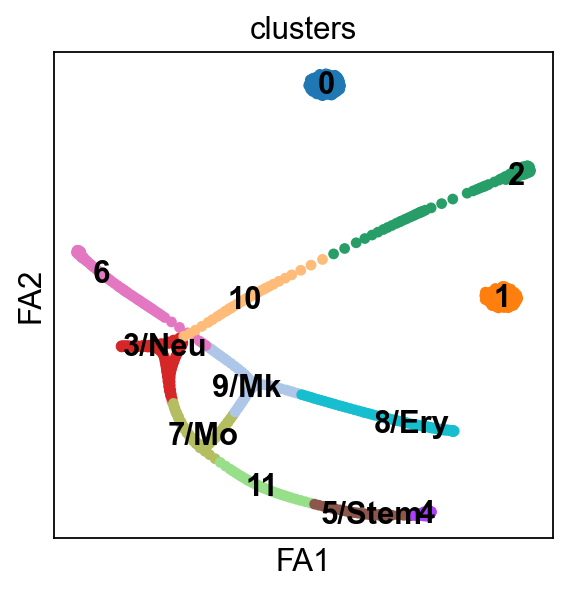

In [16]:
sc.pl.draw_graph(adata, color='clusters', legend_loc='on data')

In [17]:
sc.tl.paga(adata, groups='clusters')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


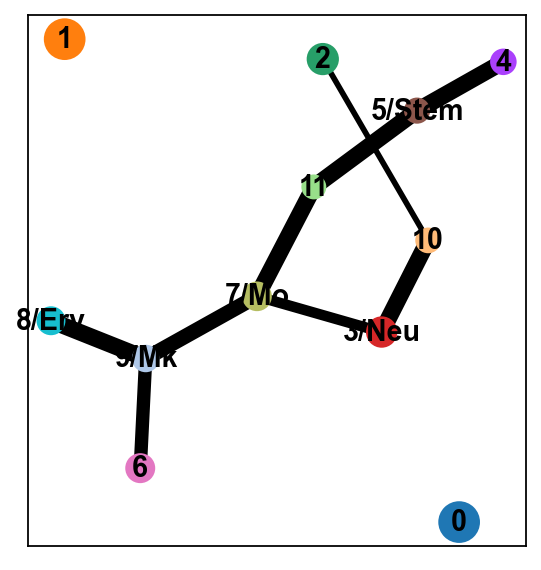

In [18]:
sc.pl.paga(adata)

--> added 'pos', the PAGA positions (adata.uns['paga'])


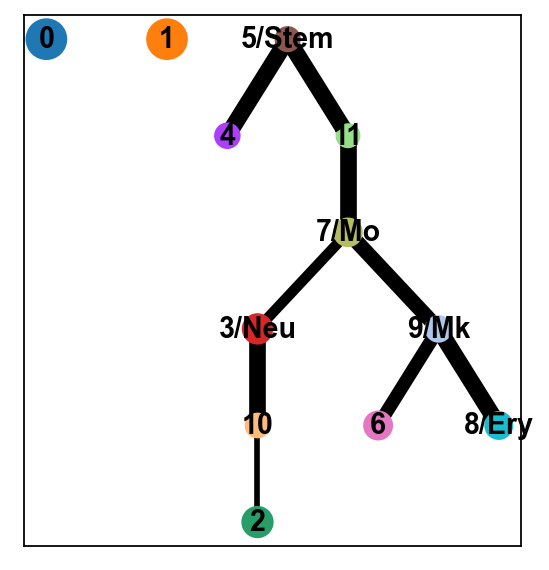

In [19]:
sc.pl.paga(adata, layout='rt', root=[5, 0, 1])

In [21]:
sc.tl.draw_graph(adata, init_pos="paga", layout="fr")

drawing single-cell graph using layout 'fr'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:01)


In [22]:
X = adata.obsm['X_draw_graph_fr'].copy()

In [23]:
adata.obsm['X_draw_graph_fr'] = X.copy()
# adata.obsm['X_draw_graph_fr'][adata.obs['clusters'] == '0', 1] -= 400
adata.obsm['X_draw_graph_fr'][adata.obs['clusters'] == '0', 0] += 500
# adata.obsm['X_draw_graph_fr'][adata.obs['clusters'] == '1', 1] -= 1000
adata.obsm['X_draw_graph_fr'][adata.obs['clusters'] == '1', 0] -= 500

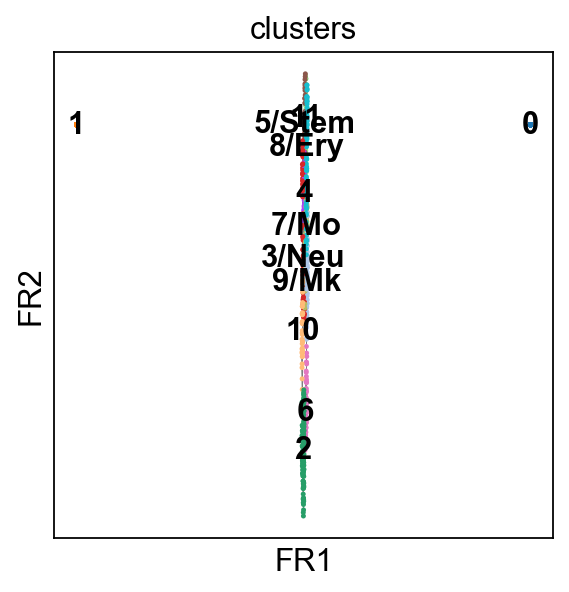

In [24]:
sc.pl.draw_graph(adata, color='clusters', edges=True, size=20, legend_loc='on data')

Harmonize the colors

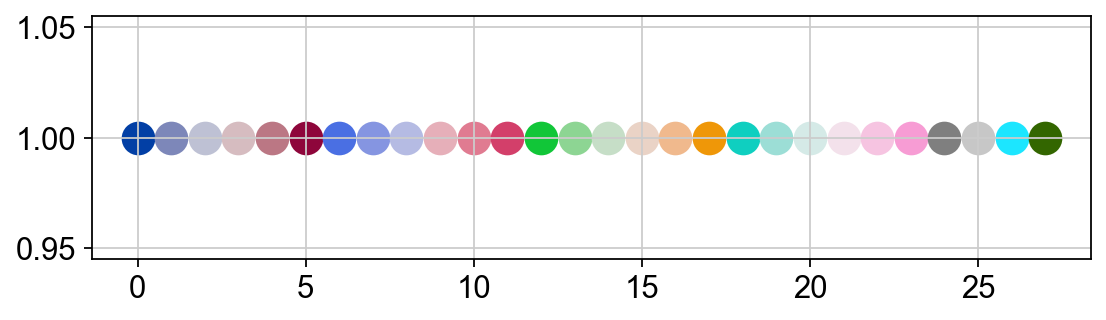

In [29]:
pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_28[i], s=200)
pl.show()

In [30]:
orig_colors = np.array(sc.pl.palettes.zeileis_28)
new_colors = orig_colors.copy()

In [31]:
new_colors[[4, 6]] = orig_colors[[12, 13]]  # Stem colors / green
new_colors[[8, 10]] = orig_colors[[5, 10]]  # Ery colors / red
new_colors[[9]] = orig_colors[[17]]       # Mk early Ery colors / yellow
new_colors[[2, 3]] = orig_colors[[2, 25]]   # lymph progenitors / grey
new_colors[[3, 11]] = orig_colors[[6, 7]]  # Neu / light blue
new_colors[[7, 12]] = orig_colors[[0, 1]]  # Mo / dark blue

In [32]:
adata.uns['clusters_colors'] = new_colors

In [33]:
adata.obs['clusters'].cat.categories = [
    '0', '1', '2', '3/Neu\n\n', '4', '         5/Stem\n\n', '6', '7/Mo\n\n', '8/Ery\n\n', '         9/Mk\n\n',
    '10', '11']

--> added 'pos', the PAGA positions (adata.uns['paga'])


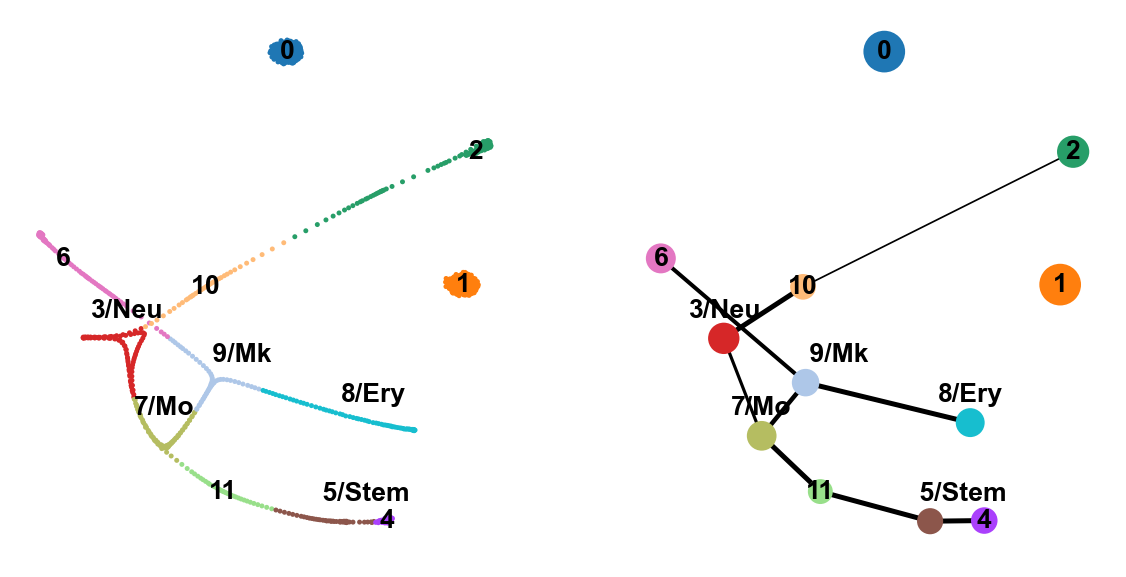

In [73]:
axs = sc.pl.paga_compare(
    adata, title='', right_margin=0.2, size=20, edge_width_scale=0.3,
    legend_fontsize=12, fontsize=12, frameon=False, show=False)

In [74]:
axs[0]

In [75]:
pl.sca(axs[0])
pl.xlabel('')
pl.ylabel('')
axs[0].set_frame_on(False)
pl.savefig('./figures/paga_compare_simulated.pdf')
pl.show()

ValueError: Axes instance argument was not found in a figure

In [77]:
adata.write(results_file)

In [78]:
adata = sc.read(results_file)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


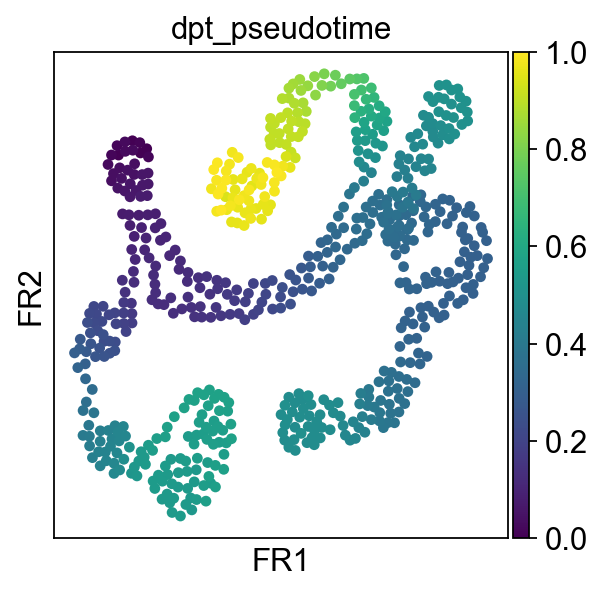

In [82]:
sc.tl.dpt(adata)
sc.pl.draw_graph(adata, color='dpt_pseudotime')

In [83]:
adata.obs['distance'] = adata.obs['dpt_pseudotime']

In [84]:
paths = [('erythrocytes', [5, 6, 4, 2, 10, 8]),
         ('neutrophils', [5, 6, 11, 3]),
         ('monocytes', [5, 6, 4, 2, 7])]

In [85]:
adata.var_names

Index(['Gata2', 'Gata1', 'Fog1', 'EKLF', 'Fli1', 'SCL', 'Cebpa', 'Pu.1',
       'cJun', 'EgrNab', 'Gfi1'],
      dtype='object')

In [86]:
gene_names = ['Gata2', 'Gata1', 'SCL', 'Fog1', 'EKLF', 'Fli1', 'Cebpa', 'Gfi1', 'Pu.1', 'cJun', 'EgrNab']

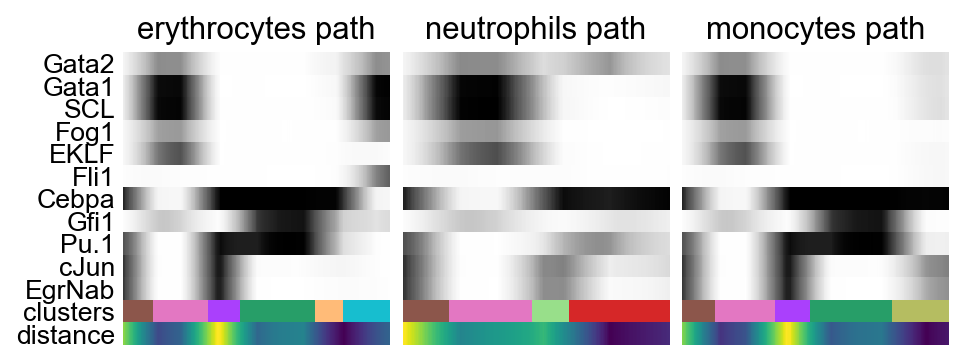

In [87]:
_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.savefig('./figures/paga_path_simulated.pdf')
pl.show()